# Image segmentation by custom U-Net model
- Dataset : 복부 X-ray (장내 용종, 종양 절제술 전후 사진)
   - calss 1 (air)
   - class 2 (background) : class 1에 속하지 않는 경우 모두 bg 처리

## 1. Packages

In [1]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

import cv2 
from PIL import Image

## 2. Load and Split the data

In [2]:
import os
import numpy as np
import pandas as pd
import imageio

import matplotlib.pyplot as plt
%matplotlib inline

input_dir = '/content/drive/MyDrive/Colab Notebooks/data/train/image/'
target_dir = '/content/drive/MyDrive/Colab Notebooks/data/train/label/'

# sorted함수를 사용하여 정렬된 파일 리스트를 반환
# 이터러블 객체도 받을 수 있음 
image_list = sorted(
    [
     os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith('.jpg')
    ])

mask_list = sorted(
    [
     os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith('png') and not fname.startswith('.')
    ])

In [3]:
val_input_dir = '/content/drive/MyDrive/Colab Notebooks/data/validation/image/'
val_target_dir = '/content/drive/MyDrive/Colab Notebooks/data/validation/label/'

# sorted함수를 사용하여 정렬된 파일 리스트를 반환
# 이터러블 객체도 받을 수 있음 
val_image_list = sorted(
    [
     os.path.join(val_input_dir, fname)
     for fname in os.listdir(val_input_dir)
     if fname.endswith('.jpg')
    ]
)

val_mask_list = sorted(
    [
     os.path.join(val_target_dir, fname)
     for fname in os.listdir(val_target_dir)
     if fname.endswith('png') and not fname.startswith('.')
    ]
)

Text(0.5, 1.0, 'Segmentation')

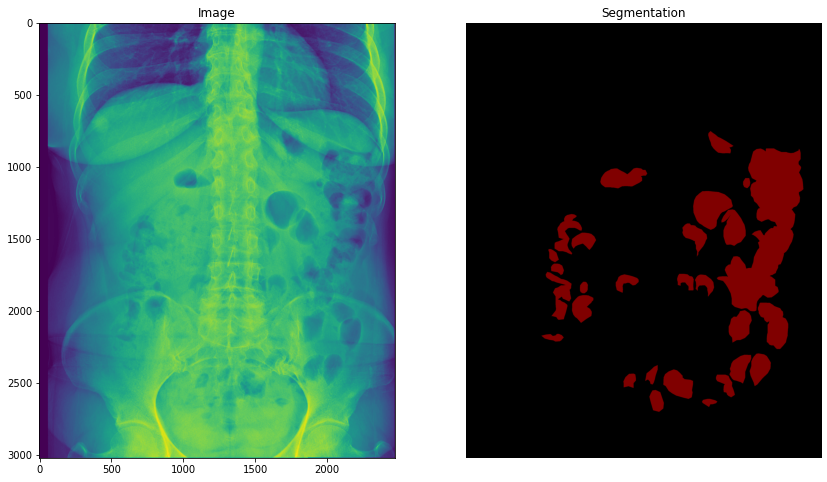

In [4]:
# check train image and mask data
N = 2
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])


fig, arr = plt.subplots(1, 2, figsize=(14, 10))
plt.axis('off')
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask)
arr[1].set_title('Segmentation')

In [5]:
# split 'train' dataset into image and mask image
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

In [6]:
for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/Colab Notebooks/data/train/image/02715030000.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/Colab Notebooks/data/train/label/02715030000.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/Colab Notebooks/data/train/image/0547296_post0000.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/Colab Notebooks/data/train/label/0547296_post0000.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/Colab Notebooks/data/train/image/0547296_pre0000.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/Colab Notebooks/data/train/label/0547296_pre0000.png'>)


In [7]:
image_filenames = tf.constant(image_list)
mask_filenames = tf.constant(mask_list)
print(image_filenames[0])
print(mask_filenames[0])

tf.Tensor(b'/content/drive/MyDrive/Colab Notebooks/data/train/image/02715030000.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/drive/MyDrive/Colab Notebooks/data/train/label/02715030000.png', shape=(), dtype=string)


In [8]:
dataset = tf.data.Dataset.from_tensor_slices((image_filenames, mask_filenames))
for image, mask in dataset.take(1):
  print(image)
  print(mask) 

tf.Tensor(b'/content/drive/MyDrive/Colab Notebooks/data/train/image/02715030000.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/drive/MyDrive/Colab Notebooks/data/train/label/02715030000.png', shape=(), dtype=string)


In [9]:
# split 'validation' dataset into image and mask image
val_image_list_ds = tf.data.Dataset.list_files(val_image_list, shuffle=False)
val_mask_list_ds = tf.data.Dataset.list_files(val_mask_list, shuffle=False)

val_image_filenames = tf.constant(val_image_list)
val_mask_filenames = tf.constant(val_mask_list)

val_dataset = tf.data.Dataset.from_tensor_slices((val_image_filenames, val_mask_filenames))
for image, mask in val_dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'/content/drive/MyDrive/Colab Notebooks/data/validation/image/10843610000.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/drive/MyDrive/Colab Notebooks/data/validation/label/10843610000.png', shape=(), dtype=string)


In [10]:
# Define image data preprocessing function
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (128, 96), method='nearest')
    input_mask = tf.image.resize(mask, (128, 96), method='nearest')

    return input_image, input_mask/128

In [11]:
# train dataset
image_ds = dataset.map(process_path)
train_processed_image_ds = image_ds.map(preprocess)

# validatoin dataset
val_image_ds = val_dataset.map(process_path)
val_processed_image_ds = val_image_ds.map(preprocess)

# 3. Generate custom model : DoubleUNet
- fine tune U-Net 
- get the gradient of loss function twice

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def ConvLayer(in_channels, out_channels):
    layers = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(inplace=True),
        
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(inplace=True),
    )
    return layers

In [13]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block1 = ConvLayer(in_channels=3, out_channels=64)
        self.conv_block2 = ConvLayer(in_channels=64, out_channels=128)
        self.conv_block3 = ConvLayer(in_channels=128, out_channels=256)
        self.conv_block4 = ConvLayer(in_channels=256, out_channels=512)
        self.conv_block5 = ConvLayer(in_channels=512, out_channels=1024)
        self.pool = nn.MaxPool2d(kernel_size=2)
        
    def forward(self, x):
        encode_features = []
        out = self.conv_block1(x)
        encode_features.append(out)
        out = self.pool(out)
        
        out = self.conv_block2(out)
        encode_features.append(out)
        out = self.pool(out)
        
        out = self.conv_block3(out)
        encode_features.append(out)
        out = self.pool(out)
        
        out = self.conv_block4(out)
        encode_features.append(out)
        out = self.pool(out)
        
        out = self.conv_block5(out)
        return out, encode_features

In [14]:
encoder = Encoder()
x = torch.randn(2,3,128,96)
out, ftrs = encoder(x)
print(len(ftrs))

4


In [15]:
for ftr in ftrs:
  print(ftr.shape)
print(out.shape)

torch.Size([2, 64, 128, 96])
torch.Size([2, 128, 64, 48])
torch.Size([2, 256, 32, 24])
torch.Size([2, 512, 16, 12])
torch.Size([2, 1024, 8, 6])


In [16]:
def UpConvLayer(in_channels, out_channels):
    layers = nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(inplace=True)
    )
    return layers

In [17]:
from torchvision import transforms
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.upconv_layer1 = UpConvLayer(in_channels=1024, out_channels=512)
        self.conv_block1 = ConvLayer(in_channels=512+512, out_channels=512)
        
        self.upconv_layer2 = UpConvLayer(in_channels=512, out_channels=256)
        self.conv_block2 = ConvLayer(in_channels=256+256, out_channels=256)
        
        self.upconv_layer3 = UpConvLayer(in_channels=256, out_channels=128)
        self.conv_block3 = ConvLayer(in_channels=128+128, out_channels=128)
        
        self.upconv_layer4 = UpConvLayer(in_channels=128, out_channels=64)
        self.conv_block4 = ConvLayer(in_channels=64+64, out_channels=64)



        
    def forward(self, x, encoder_features):
        out = self.upconv_layer1(x)
        croped_enc_feature = self._center_crop(encoder_features[-1], out.shape[2:])
        out = torch.cat([out, croped_enc_feature], dim=1)
        out = self.conv_block1(out)
        
        out = self.upconv_layer2(out)
        croped_enc_feature = self._center_crop(encoder_features[-2], out.shape[2:])
        out = torch.cat([out, croped_enc_feature], dim=1)
        out = self.conv_block2(out)
        
        out = self.upconv_layer3(out)
        croped_enc_feature = self._center_crop(encoder_features[-3], out.shape[2:])
        out = torch.cat([out, croped_enc_feature], dim=1)
        out = self.conv_block3(out)
        
        out = self.upconv_layer4(out)
        croped_enc_feature = self._center_crop(encoder_features[-4], out.shape[2:])
        out = torch.cat([out, croped_enc_feature], dim=1)
        out = self.conv_block4(out)
        return out

    def _center_crop(self, encoder_feature, decoder_feature_size):
        croped_features = transforms.CenterCrop(size=decoder_feature_size)(encoder_feature)
        return croped_features

In [18]:
encoder = Encoder()
decoder = Decoder()
x = torch.randn(2, 3, 128, 96)
out, ftrs = encoder(x)
out = decoder(out, ftrs)

In [19]:
print(out.shape)

torch.Size([2, 64, 128, 96])


In [20]:
# class OutConv(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(OutConv, self).__init__()
#         self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
#         self.activation_layer = nn.LeakyReLU(True)
    
#     def forward(self, x):
#         x = self.conv(x)
#         x= self.activation_layer(x)
#         return x

In [21]:
# class UNet(nn.Module):
#     def __init__(self, n_channels, n_classes):
#         super(UNet, self).__init__()
#         self.n_channels = n_channels
#         self.n_classes = n_classes
    

#         self.inc = DoubleConv(n_channels, 64)
#         self.down1 = Encoder(64, 128)
#         self.down2 = Encoder(128, 256)
#         self.down3 = Encoder(256, 512)
#         self.down4 = Encoder(512, 1024)
        
#         self.up1 = Decoder(1024, 512)
#         self.up2 = Decoder(512, 256)
#         self.up3 = Decoder(256, 128)
#         self.up4 = Decoder(128, 64)
#         self.outc = OutConv(64,n_classes)

#     def forward(self, x):
#         x1 = self.inc(x)
#         x2 = self.down1(x1)
#         x3 = self.down2(x2)
#         x4 = self.down3(x3)
#         x5 = self.down4(x4)

#         x = self.up1(x5, x4)
#         x = self.up2(x, x3)
#         x = self.up3(x, x2)
#         x = self.up4(x, x1)
#         logits = self.outc(x)
#         return logits


In [22]:
class UNet(nn.Module):
    def __init__(self, num_classes, retain_input_dim=True):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.head = nn.Conv2d(64, num_classes, kernel_size=1)
        self.retain_input_dim = retain_input_dim
        
    def forward(self, x):
        out, encode_features = self.encoder(x)
        out = self.decoder(out, encode_features)
        out = self.head(out)
        if self.retain_input_dim:
            _, _, H, W = x.shape
            out = F.interpolate(out, size=(H,W))
        return out

In [23]:
# class DoubleUNet(nn.Module):
#     def __init__(self,  num_classes, retain_input_dim=True):
#         super().__init__()
      
#         self.num_classes = num_classes
#         self.first_unet = UNet(num_classes)
#         self.second_unet = UNet(num_classes)
#         # self.sigmoid = nn.Sigmoid()
#         self.retain_input_dim = retain_input_dim
#         self.out = None
    
#     def forward(self, x):
#         x1 = self.first_unet(x)
#         out = self.second_unet(x1)
#         out = tf.convert_to_tensor(out)
#         return out[:3]
    
#     # def get_output(self):
#     #     return self.sigmoid(self.out)

In [24]:
model = UNet(2)
x = torch.randn(2, 3, 128, 96)
out, ftrs = encoder(x)
out = decoder(out, ftrs)

In [25]:
print(out.shape)

torch.Size([2, 64, 128, 96])


In [26]:
model = UNet(2)
x = torch.randn(10,3,128,96)
out = model(x)
print(f"input shape: {x.shape}")
print(f"output shape: {out.shape}")

input shape: torch.Size([10, 3, 128, 96])
output shape: torch.Size([10, 2, 128, 96])


## 4. Dice Similarity Coefficient(DSC) 
- Dice loss = 1- DSC

In [27]:
from torch.utils.data import DataLoader

In [28]:
img_height = 128
img_width = 96

In [29]:
class xray_dataset():
    def __init__(self, data_dir, phase, transformer=None):
        self.phase = phase
        self.images_dir = os.path.join(data_dir, phase, "image")
        self.masks_dir = os.path.join(data_dir, phase, "label")
        self.image_files = [filename for filename in os.listdir(self.images_dir) if filename.endswith("jpg")]
        self.mask_files = [filename for filename in os.listdir(self.masks_dir) if filename.endswith("png")]
        assert len(self.image_files) == len(self.mask_files)
        
        self.transformer = transformer
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, index):
        image = cv2.imread(os.path.join(self.images_dir, self.image_files[index]))
        image = cv2.resize(image, dsize=(img_height,img_width), interpolation=cv2.INTER_LINEAR)
        mask = cv2.imread(os.path.join(self.masks_dir, self.mask_files[index]))
        mask = cv2.resize(mask, dsize=(img_height,img_width), interpolation=cv2.INTER_NEAREST)
        mask[mask < 240] = 0
        mask[mask >= 240] = 255
        mask = mask / 255

  
        
        if self.transformer:
            image = self.transformer(image)
        target = torch.from_numpy(mask).long()
        return image, target

In [30]:
def build_transformer():
    transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return transformer

In [31]:
def collate_fn(batch):
    images = []
    targets = []
    for a, b in batch: 
        images.append(a)
        targets.append(b)
    images = torch.stack(images, dim=0) 
    targets = torch.stack(targets, dim=0)

    return images, targets

In [32]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/data/'
transformer = build_transformer()
tr_dataset = xray_dataset(data_dir=data_dir, phase="train", transformer=transformer)
val_dataset = xray_dataset(data_dir=data_dir, phase="validation", transformer=transformer)
tr_dataloader = DataLoader(tr_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

In [33]:
def build_dataloader(data_dir, batch_size=4):
    transformer = build_transformer()
    
    dataloaders = {}
    train_dataset = xray_dataset(data_dir=data_dir, phase="train", transformer=transformer)
    dataloaders["train"] = DataLoader(tr_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

    val_dataset = xray_dataset(data_dir=data_dir, phase="validation", transformer=transformer)
    dataloaders["val"] = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
    return dataloaders

In [34]:
for index, batch in enumerate(tr_dataloader):
    images = batch[0]
    targets = batch[1].permute(0,3,1,2)
    print(f"images shape: {images.shape}")
    print(f"masks shape: {targets.shape}")
    if index == 0:
        break

images shape: torch.Size([4, 3, 96, 128])
masks shape: torch.Size([4, 3, 96, 128])


In [35]:
# Equations of DSC
for index, batch in enumerate(tr_dataloader):
    images = batch[0]
    targets = batch[1]
    predictions = model(images)
    
    if index == 0:
        break

In [36]:
print(predictions.shape)
print(targets.shape)

torch.Size([4, 2, 96, 128])
torch.Size([4, 96, 128, 3])


In [37]:
num_classes = 3

predictions_ = torch.argmax(predictions, dim=1)
onehot_pred = F.one_hot(predictions_, num_classes=num_classes).permute(0, 3, 1, 2)
onehot_target = F.one_hot(targets.permute(0,3,1,2)).squeeze(-1)
print(onehot_pred.shape)
print(onehot_target.shape)

torch.Size([4, 3, 96, 128])
torch.Size([4, 3, 96, 128])


In [38]:
onehot_pred_ = onehot_pred[0]
onehot_target_ = onehot_target[0]

dice_coeff = 0
for class_index in range(1, num_classes):
    a = onehot_pred_[class_index]
    b = onehot_target_[class_index]
    set_inter = torch.dot(a.reshape(-1).float(), b.reshape(-1).float())
    set_sum = a.sum() + b.sum()
    dice_coeff += (2 * set_inter) / (set_sum + 1e-9)
dice_coeff /= num_classes

In [39]:
dice_loss = 1. - dice_coeff

### Implementation of Loss function

In [40]:
class UNet_metric():
    def __init__(self, num_classes):
        self.num_classes = num_classes
        
    def __call__(self, pred, target):
        onehot_pred = F.one_hot(torch.argmax(pred, dim=1), num_classes=self.num_classes).permute(0, 3, 1, 2)
        onehot_target = F.one_hot(target.permute(0, 3, 1, 2)).squeeze(-1)
        dice_loss = self._get_dice_loss(onehot_pred, onehot_target)
        dice_coefficient = self._get_batch_dice_coefficient(onehot_pred, onehot_target)
        return dice_loss, dice_coefficient
    
    def _get_dice_coeffient(self, pred, target):
        set_inter = torch.dot(pred.reshape(-1).float(), target.reshape(-1).float())
        set_sum = pred.sum() + target.sum()
        if set_sum.item() == 0:
            set_sum = 2 * set_inter
        dice_coeff = (2 * set_inter) / (set_sum + 1e-9)
        return dice_coeff
    
    def _get_multiclass_dice_coefficient(self, pred, target):
        dice = 0
        for class_index in range(1, self.num_classes):
            dice += self._get_dice_coeffient(pred[class_index], target[class_index])
        return dice / self.num_classes
    
    def _get_batch_dice_coefficient(self, pred, target):
        num_batch = pred.shape[0]
        dice = 0
        for batch_index in range(num_batch):
            dice += self._get_multiclass_dice_coefficient(pred[batch_index], target[batch_index])
        return dice / num_batch
    
    def _get_dice_loss(self, pred, target):
        return 1 - self._get_batch_dice_coefficient(pred, target)

In [41]:
criterion = UNet_metric(num_classes=2)
criterion(predictions, targets)

(tensor(0.7984), tensor(0.2016))

## 5. Application of SGDM optimization
- SGD + Momentum

In [42]:
optimizer = torch.optim.SGD(model.parameters(), lr= 1E-3, momentum=0.9)

In [43]:
for index, batch in enumerate(tr_dataloader):
    images = batch[0]
    targets = batch[1]
    predictions = model(images)
    criterion(predictions, targets)
    if index == 1:
        break

## 6. Train the model

In [44]:
def train_one_epoch(dataloaders, model, optimizer, criterion, device):
    dice_coefficients = {}
    
    for phase in ["train", "val"]:
        running_dice_coeff = 0.0
        
        if phase == "train":
            model.train()
        else:
            model.eval()
        
        for index, batch in enumerate(dataloaders[phase]):
            images = batch[0].to(device)
            targets = batch[1].to(device)
            
            with torch.set_grad_enabled(phase == "train"):
                predictions = model(images)
                dice_coefficient = criterion(predictions, targets)
                
                if phase == "train":
                    optimizer.zero_grad()
                    dice_coefficient.backward()
                    optimizer.step()
            
            running_dice_coeff += dice_coefficient.item()
            
            if phase == "train":
                if index % 100 == 0:
                    text = f"{index}/{len(dataloaders[phase])}" + \
                            f" - Running Dice: {dice_coefficient.item():.4f}" 
                    print(text)

        dice_coefficients[phase] = running_dice_coeff / len(dataloaders[phase])
    return dice_coefficients

In [45]:
def save_model(model_state, model_name, save_dir="/content/drive/MyDrive/Colab Notebooks/data/trained_model"):
    os.makedirs(save_dir, exist_ok=True)
    torch.save(model_state, os.path.join(save_dir, model_name))

In [46]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/data/'
NUM_CLASSES = 4
BATCH_SIZE = 12
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataloaders = build_dataloader(data_dir, batch_size=BATCH_SIZE)
model = UNet(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
criterion = UNet_metric(num_classes=NUM_CLASSES)
optimizer = torch.optim.SGD(model.parameters(), lr= 1E-3, momentum=0.9)

In [47]:
num_epochs = 10

best_epoch = 0
best_score = 0.0
train_dice_coefficient = []
val_dice_coefficient = []

for epoch in range(num_epochs):
    dice_coefficients = train_one_epoch(dataloaders, model, optimizer, criterion, DEVICE)
    train_dice_coefficient.append(dice_coefficients["train"])
    val_dice_coefficient.append(dice_coefficients["val"])
    
    print(f"{epoch}/{num_epochs} - Train Dice Coeff: {dice_coefficients['train']:.4f}, Val Dice Coeff: {dice_coefficients['val']:.4f}")
    
    if (epoch > 3) and (dice_coefficients["val"] > best_score):
        best_epoch = epoch
        best_score = dice_coefficients["val"]
        save_model(model.state_dict(), f"model_{epoch:02d}.pth")
        
print(f"Best epoch: {best_epoch} -> Best Dice Coeffient: {best_score:.4f}")

IndexError: ignored